<a href="https://colab.research.google.com/github/Achraf-Trabelsi/PFA-NLP/blob/main/LSTM_w_pos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os 
import tensorflow as tf
from tensorflow import keras
from keras import layers
path='/content/drive/MyDrive/PFA/'
data=pd.read_csv(f'{path}dataset.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15594 entries, 0 to 15593
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      15594 non-null  object
 1   text    15594 non-null  object
 2   pos     15594 non-null  object
 3   arg     15594 non-null  object
dtypes: object(4)
memory usage: 487.4+ KB


In [ ]:
from keras.preprocessing.text import Tokenizer

t = Tokenizer()
t.fit_on_texts([text for text in data['text'].values])
vocab_size = len(t.word_index)+1

In [ ]:
max_seq_length=800

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils

X = data[['text','pos']].values
y = data['arg'].values
pos = X[:,1]


y=[np.array([float(x1) for x1 in x.split()]) for x in y]
pos=[np.array([float(x1) for x1 in x.split()]) for x in pos]


pos_padded = pad_sequences(pos, maxlen=max_seq_length,padding='post')
y_padded = pad_sequences(y, maxlen=max_seq_length,padding='post')

pos_cat = np_utils.to_categorical(pos_padded)
y_cat = np_utils.to_categorical(y_padded)

In [ ]:
np.array(pos_padded).shape

(15594, 800)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(pos_cat,y_cat, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

(12475, 800, 46)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import Sequential
from keras.models import Model

def modelLSTM_pos(input_shape,internal_units,output_size):
    input_lstm = layers.Input(shape=input_shape)
    lstm = layers.LSTM(input_shape=input_shape,units=internal_units,return_sequences=True)(input_lstm)
    output= layers.TimeDistributed(layers.Dense(output_size,activation='softmax'))(lstm)
    model = Model(inputs=input_lstm, outputs=output)
    return model

In [ ]:
model_pos = modelLSTM_pos(input_shape=(X_train.shape[1],X_train.shape[2]),internal_units=64,output_size=y_test.shape[2])
model_pos.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 800, 46)]         0         
                                                                 
 lstm (LSTM)                 (None, 800, 64)           28416     
                                                                 
 time_distributed (TimeDistr  (None, 800, 8)           520       
 ibuted)                                                         
                                                                 
Total params: 28,936
Trainable params: 28,936
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_pos.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
history=model_pos.fit(x=X_train, y=y_train, batch_size=256, epochs=10, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
49/49 [==============================] - 11s 97ms/step - loss: 1.1462 - categorical_accuracy: 0.7128 - val_loss: 0.7390 - val_categorical_accuracy: 0.7729
Epoch 2/10
49/49 [==============================] - 4s 73ms/step - loss: 0.7004 - categorical_accuracy: 0.7823 - val_loss: 0.6900 - val_categorical_accuracy: 0.7821
Epoch 3/10
49/49 [==============================] - 4s 73ms/step - loss: 0.6706 - categorical_accuracy: 0.7846 - val_loss: 0.6590 - val_categorical_accuracy: 0.7838
Epoch 4/10
49/49 [==============================] - 4s 73ms/step - loss: 0.6431 - categorical_accuracy: 0.7850 - val_loss: 0.6340 - val_categorical_accuracy: 0.7841
Epoch 5/10
49/49 [==============================] - 4s 73ms/step - loss: 0.6108 - categorical_accuracy: 0.7968 - val_loss: 0.6065 - val_categorical_accuracy: 0.8063
Epoch 6/10
49/49 [==============================] - 4s 73ms/step - loss: 0.5866 - categorical_accuracy: 0.8070 - val_loss: 0.5834 - val_categorical_accuracy: 0.8067
Epoch 7/1

In [ ]:
loss, accuracy = model_pos.evaluate(X_test,  y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

98/98 [==============================] - 1s 13ms/step - loss: 0.5627 - categorical_accuracy: 0.8109
Accuracy: 81.093538


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
ydl_pred = np.argmax(model_pos.predict(X_test), axis=-1)
y_true = np.argmax(y_test,axis=-1)

In [ ]:
cm=[ f1_score(y_t,y_p,average='weighted') for y_t,y_p in zip(y_true,ydl_pred)]
np.mean(cm)

0.7769034216906779

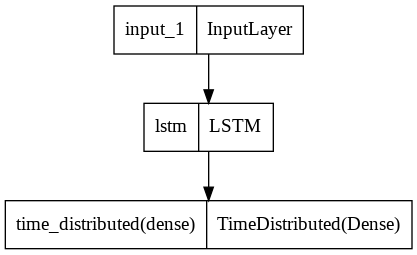

In [ ]:
tf.keras.utils.plot_model(model_pos, to_file='/content/drive/MyDrive/PFA/lstm_pos.png')